# Home - work - other inference 
This notebook contains the detail information to infer home, work and others stations per user.

We use a rank-based methodology to infer these stations. First, for each user, we rank stations by frequency. Rank-1 is labeled as home, rank-2 is label as work, and rank-3+ are label as other activities. 

We use row_number() algorith to rank 1,2,3,4 (no ties if two stations have the same number of transactions) 

In [1]:
import pyspark as ps
from pyspark.sql.functions import *
sc = ps.SparkContext(appName="home_work")

In [2]:
from os import path
import time 
import random 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import glob
import geopandas as gpd
warnings.filterwarnings('ignore')

from pyspark.sql.functions import *
from pyspark.sql import * #This enables the SparkSession object
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.functions import pow, col, sqrt

spark = SparkSession.builder\
        .master("local") \
        .appName("home_work_df") \
        .getOrCreate()

## Process 
- map new ids 
- filter frequent users (I would need to create a frequent/non-frequen users file again with the new IDs)[before march 8]
- filter out observation after march 8. We will work only with observations between Jan-01-2020, and March-8-2020. 
- Merge with clean stations as well. 
- Find ranks per ID 
- Create a file with the following columns: ID, Home_station, Work_station


In [ ]:
def time_format(df, date_col = 'fechatransaccion', time_col = "horatransaccion"):
    ''' Returns dataframe with date and time as a timespamt format
    Input: 
     - df: PySpark dataframe: Raw transactions
     - date_col: str. Column name for date 
     - time_col: str. Column name for time
     
     Return: 
     PySpark dataframe. 
     Time col:
     - timestamp: time in 'to_timestamp' format '''
    # add time
    df = df.withColumn("timestamp",
        to_timestamp(col(time_col),"HH:mm:ss"))\
        .withColumn("hour", hour(col("timestamp")))\
        .withColumn("minute", minute(col("timestamp")))\
        .withColumn("second", second(col("timestamp")))\
        .withColumn('time', col('hour') + col('minute')/60 + col('second')/3600)
    
    # add date
    df = df.withColumn('date', to_date(unix_timestamp(col(date_col), 'yyyyMMdd').cast("timestamp")))
    return df

In [ ]:
output_path = '../data/output/'
input_path = '../data/input/'

transactions = spark.read.csv(output_path + 'tables/transactions_frequent_users.csv',
                              header =True, sep = ',')


df = transactions.transform(lambda df: time_format(df))\
    .groupBy(['card_id', 'station_name'])\
    .agg({'fechatransaccion':'count', 'time': 'mean'})\
    .withColumn('rank',row_number().over(Window.partitionBy("card_id").orderBy(desc("count(fechatransaccion)"))))



In [ ]:
home_location = df.filter(df.rank == 1).select(col('card_id'), 
                                               col('station_name').alias('home_station'), 
                                               col('count(fechatransaccion)').alias('transacciones_h'), 
                                               col('rank').alias('rank_h'), 
                                               col('avg(time)').alias('time_h'))

work_location = df.filter(df.rank == 2).select(col('card_id'), 
                                               col('station_name').alias('work_station'), 
                                               col('count(fechatransaccion)').alias('transacciones_w'), 
                                               col('rank').alias('rank_w'),
                                               col('avg(time)').alias('time_w'))

other_location = df.filter(df.rank == 3).select(col('card_id'), 
                                               col('station_name').alias('other_station'), 
                                               col('count(fechatransaccion)').alias('transacciones_o'), 
                                               col('rank').alias('rank_o'),
                                               col('avg(time)').alias('time_o'))

In [ ]:
final_df = home_location.join(work_location, on = 'card_id', how = 'inner')\
                        .join(other_location, on = 'card_id', how = 'left').cache()

In [ ]:
%%time 
hw_location = final_df.toPandas()
hw_location.to_csv(output_path + 'tables/hw_location.csv', index = False)

## Validation plots 

In [3]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [4]:
output_path = '../data/output/'
input_path = '../data/input/'

# Localidades shapefiles
lsoas = gpd.read_file(input_path + 'localidades_shp/Loca.shp')
lsoas.drop(index = 8, inplace= True )

#Troncales shapefiles
troncal = gpd.read_file(input_path + 'troncal_shape/corredores-troncal-tm.shp')

#Stations 
stations = pd.read_csv(input_path + 'stations.csv')[['station_name', 'latitude', 'longitude']].drop_duplicates(subset =  'station_name')

#hw_locations 
hw_locations = pd.read_csv(output_path + 'tables/hw_location.csv')


### Heatmap 

In [6]:
# Obtain get coordiantes
home = hw_locations.merge(stations, how = 'left', 
                          left_on = 'home_station', 
                          right_on='station_name')

work = hw_locations.dropna().merge(stations, how = 'left', 
                                   left_on = 'work_station', 
                                   right_on='station_name')

other = hw_locations.dropna().merge(stations, how = 'left', 
                                    left_on = 'other_station',
                                    right_on='station_name')

sample_size = 10000
home_ = home.sample(sample_size *4).dropna()
work_ = work.sample(sample_size).dropna()
other_ = other.sample(sample_size).dropna()

In [7]:
# # Density plots with Geopandas (They look really nice plots)
# gdf = gpd.GeoDataFrame(
#     home_, geometry=gpd.points_from_xy(home_.longitude, home_.latitude))

# import geoplot

# ax = geoplot.kdeplot(
#     gdf, clip=lsoas.geometry,
#     shade=True, cmap='hot',legend=True)
# geoplot.polyplot(lsoas, ax=ax)

In [8]:
# To do
# Try using heatmap instead fot his plot. It may look nicer, and it may also give you the catchment areas instead. 

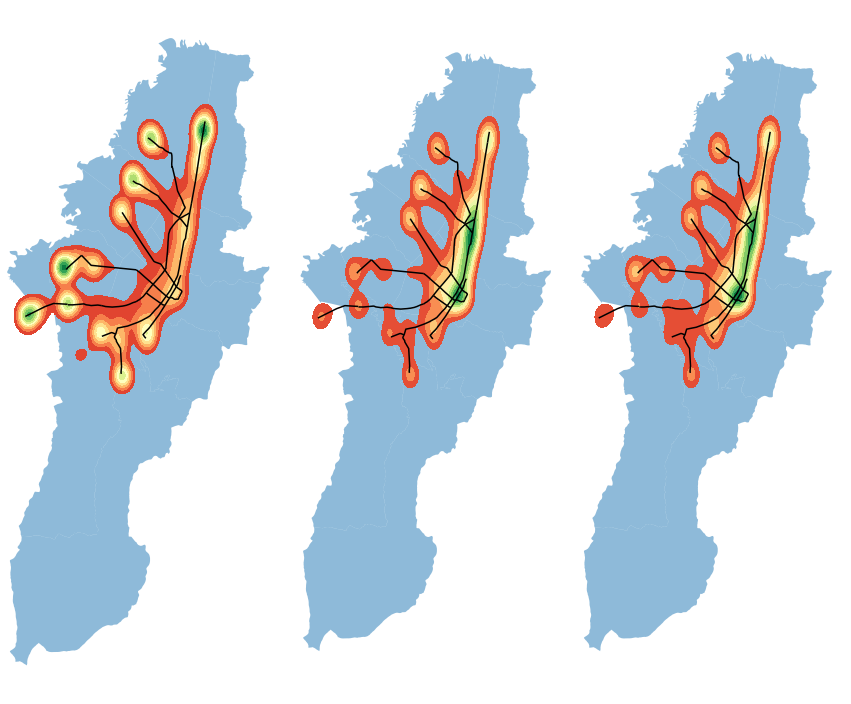

In [25]:
fontsize = 18
#Plotting distributions rank 1, rank2 and rank 3 stations. 
f, axes = plt.subplots(nrows = 1, ncols = 3,figsize=(15, 15))

lsoas.plot(alpha=0.5, linewidth=1, axes = axes[0])
sns.kdeplot(home_.longitude ,home_.latitude,shade = True, 
            shade_lowest=False, cmap = 'RdYlGn', ax = axes[0])
troncal.plot(alpha=1, color= 'Black', axes = axes[0])
axes[0].set_axis_off()
# axes[0].set_title("Rank-1 density distribution\n Home stations",
#                       fontsize = fontsize)

lsoas.plot(alpha=0.5, linewidth=1, axes = axes[1])
sns.kdeplot(work_.longitude ,work_.latitude,shade = True, 
            shade_lowest=False, cmap = 'RdYlGn', ax = axes[1])
troncal.plot(alpha=1, color= 'Black', axes = axes[1])
axes[1].set_axis_off()
# axes[1].set_title("Rank-2 density distribution\n Work stations",
#                       fontsize = fontsize)


lsoas.plot(alpha=0.5, linewidth=1, axes = axes[2])
sns.kdeplot(other_.longitude ,other_.latitude,shade = True, 
            shade_lowest=False, cmap = 'RdYlGn', ax = axes[2])
troncal.plot(alpha=1, color= 'Black', axes = axes[2])
axes[2].set_axis_off()
# axes[2].set_title("Rank-3 density distribution\n Other stations",
#                       fontsize = fontsize);
plt.subplots_adjust(wspace = 0.02)

f.savefig(output_path + 'figures/figure-2-1.pdf')

### Average transaction time by rank

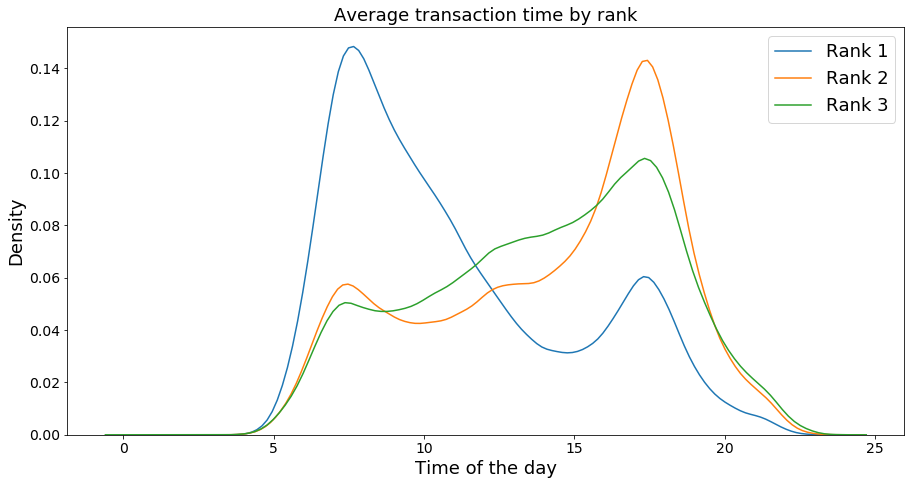

In [26]:
fig, ax = plt.subplots(figsize = (15, 7.5))
sns.kdeplot(home.time_h, label = 'Rank 1')
sns.kdeplot(work.time_w, label = 'Rank 2')
sns.kdeplot(other.time_o, label = 'Rank 3')

# sns.distplot(transactions_strata[rank_1_filter].transaction_time, )
plt.title('Average transaction time by rank', fontsize = 18)
plt.xlabel('Time of the day',fontsize = 18)
plt.ylabel('Density',fontsize = 18)
plt.legend(fontsize = 18);

fig.savefig(output_path + 'figures/figure-2-2.pdf')